In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import sys
sys.path.append("./script")


# Data-Set Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dataloader import CustomDataset

path_to_dataset = '/content/drive/MyDrive/'
dir_path_train = path_to_dataset + 'datasetTrain/'
dir_path_valid = path_to_dataset + 'datasetValid/'
train_ds = CustomDataset(dir_path_train)
valid_ds = CustomDataset(dir_path_valid)
len(train_ds), len(valid_ds)

(1867, 983)

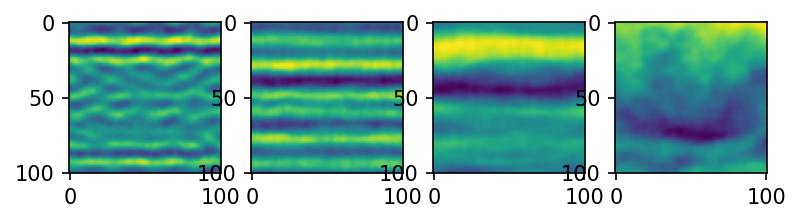

In [5]:
# plot images
x, y = valid_ds[140]
fig,ax = plt.subplots(1,4,figsize=(6,3),dpi=150)
for t in np.arange(4):
    ax[t].imshow(x[t])
plt.show()

In [6]:
training_dataloader = DataLoader(train_ds,batch_size=40,shuffle=True)
valid_dataloader = DataLoader(valid_ds,batch_size=40,shuffle=True)

In [7]:
# download data using csv reader is faster (then .. ) except in the first run,
# we start with the first run over the entiry data, to save time latter.
for x,y in tqdm(training_dataloader):
  pass
for x,y in tqdm(valid_dataloader):
  pass

100%|██████████| 25/25 [22:02<00:00, 52.92s/it]


# Time - Classifier for the VAE perceptional loss

This is a simple classifier (CNN based) for use later on the perception loss in the VAE model. It take a single image and predict to which time step this image belong to.

In [ ]:

from loss_class import lost_in_time
from model_class import Classifier_Time

loss_class = nn.CrossEntropyLoss()
net_time = Classifier_Time()

valid_epoch_info = []
train_epoch_info = []

In [ ]:
optimizer = optim.Adam(net_time.parameters(), lr=1e-4)

In [ ]:
n_epochs = 20

if torch.cuda.is_available():
    net_time.cuda()
    print("cuda")


pbar = tqdm( range(n_epochs) )

for epoch in pbar:

    
    if len(valid_epoch_info) > 1:
        pbar.set_description(' val acc:'+'{0:.5f}'.format(valid_epoch_info[-1][1])+
                             ' train acc:'+'{0:.5f}'.format(train_epoch_info[-1][1]) )
    
    net_time.train() # put the net into "training mode"
    for x,y in training_dataloader: #tqdm(training_dataloader):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()  
        optimizer.zero_grad()
        pred, ran = net_time(x)
        loss = loss_class(pred, ran)
        loss.backward()
        optimizer.step()
        
    
    net_time.eval() #put the net into evaluation mode
    
    train_epoch_info.append(lost_in_time(training_dataloader,net_time))
    valid_epoch_info.append(lost_in_time(valid_dataloader,net_time))

    if len(valid_epoch_info)>1:
      if np.amin(np.array(valid_epoch_info)[:-1,0]) > np.array(valid_epoch_info)[-1][0]:
        torch.save(net_time.state_dict(), 'trained_model_class_time.pt')

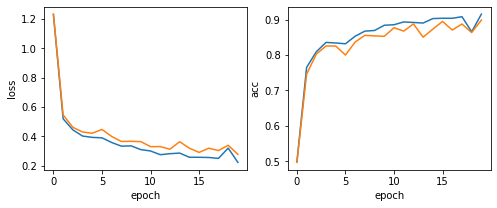

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(np.array(train_epoch_info)[:,0],label='training')
ax[0].plot(np.array(valid_epoch_info)[:,0],label='validation')

ax[1].plot(np.array(train_epoch_info)[:,1])
ax[1].plot(np.array(valid_epoch_info)[:,1])

ax[0].set_ylabel('loss')
ax[1].set_ylabel('acc')

for i in range(2):
    ax[i].set_xlabel('epoch')
plt.show()

# Velocity - Classifier for the VAE perceptional loss

This is a simple classifier (CNN based) for use later on the perception loss in the VAE model. It take set of 4 sequential images to predicit the plasma counter-stream velocity.

In [ ]:
from loss_class import compute_loss_class
from model_class import Classifier_Index

loss_class = nn.CrossEntropyLoss()
net_velocity = Classifier_Index()

valid_epoch_info = []
train_epoch_info = []

In [ ]:
optimizer = optim.Adam(net_velocity.parameters(), lr=1e-4)

In [ ]:

n_epochs = 10

if torch.cuda.is_available():
    net_velocity.cuda()
    print("cuda")



pbar = tqdm( range(n_epochs) )


for epoch in pbar:

    
    if len(valid_epoch_info) > 1:
        pbar.set_description(' val acc:'+'{0:.5f}'.format(valid_epoch_info[-1][1])+
                             ' train acc:'+'{0:.5f}'.format(train_epoch_info[-1][1]) )
    
    net_velocity.train() # put the net into "training mode"
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        optimizer.zero_grad()
        pred = net_velocity(x)
        loss = func_class(pred, y[:,0])
        loss.backward()
        optimizer.step()
    
    net_velocity.eval() #put the net into evaluation mode
    
    train_epoch_info.append(compute_loss_class(0,training_dataloader,net_velocity))
    valid_epoch_info.append(compute_loss_class(0,valid_dataloader,net_velocity))

    if len(valid_epoch_info)>1:
      if np.amin(np.array(valid_epoch_info)[:-1,0]) > np.array(valid_epoch_info)[-1][0]:
        torch.save(net_velocity.state_dict(), 'trained_model_class_velocity.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

cuda


TypeError: ignored

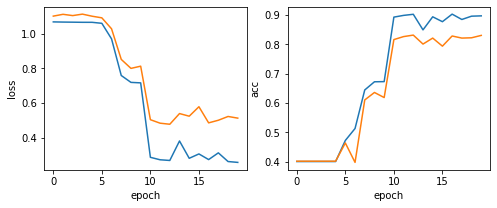

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(np.array(train_epoch_info)[:,0],label='training')
ax[0].plot(np.array(valid_epoch_info)[:,0],label='validation')

ax[1].plot(np.array(train_epoch_info)[:,1])
ax[1].plot(np.array(valid_epoch_info)[:,1])

ax[0].set_ylabel('loss')
ax[1].set_ylabel('acc')

for i in range(2):
    ax[i].set_xlabel('epoch')
plt.show()

In [ ]:
tr_param = torch.load('trained_model_class.pt',map_location='cpu')


In [ ]:
net_velocity.cpu()
model = net_velocity.classifier.state_dict()
len(tr_param.items()), len(model.items())

(16, 16)

In [ ]:
i=0
for key, par in model.items():
  i+=1
  j=0
  for key0, par0 in tr_param.items():
    j+=1
    if i==j:
        model[key].copy_(par0)

# VAE - main model

Load trained models (from the above sections in this notebook) to serve as a classifiers for the net end-points perceptional loss.

In [9]:
from model_class import Classifier_Time
net_time = Classifier_Time()
print('num of parameters:', sum(len(p.view(-1)) for p in net_time.parameters()))
net_time.load_state_dict(torch.load('./trained_models/trained_model_class_time.pt',map_location='cpu'))

num of parameters: 421784


<All keys matched successfully>

In [10]:
from model_class import Classifier_Index
net_velocity = Classifier_Index()
print('num of parameters:', sum(len(p.view(-1)) for p in net_velocity.parameters()))
net_velocity.load_state_dict(torch.load('./trained_models/trained_model_class_velocity.pt',map_location='cpu'))

num of parameters: 422483


<All keys matched successfully>

Initalize the two net: VAE (encoder and decoder) and a z-net that follow the encoder and make him a classifier.

In [11]:
from model_dimensional_reduction import Z_Classifier, VAE2


net_VAE2 = VAE2()
net_z = Z_Classifier()



from loss_dimensional_reduction import Loss_Func, Loss_Func_Info

loss_cal = Loss_Func(net_time, net_velocity)

if torch.cuda.is_available():
    net_VAE2.cuda()
    net_z.cuda()
    loss_cal.cuda()
    print("cuda")


####################
# keys values we collect at each ephoc for convergence test and over-fitting test
# 'loss': is the total loss, the same from the main loop
# 'acc_..': is accuracy test of the classifier,
# '.._z_..': refer to the z-classifiers, placed after the encoder
# '.._end_..': refer to the pre-trained classifiers, classify the results image after the decoder
# '.._vel': classify a set of image into the counter-stream velocity 
# '.._time': classify a single image into his time-step
# 'mse': mean squere error between input and decoder's output
# 'kld': KL-divergence

keys = {'loss','acc_z_time','acc_z_vel',\
              'acc_end_time','acc_end_vel','mse','kld'}
valid_info = {}
train_info = {}
for key in keys:
  valid_info[key] = []
  train_info[key] = []

#####################

In [12]:
# print('num of parameters:', sum(len(p.view(-1)) for p in net_z.parameters()))
# net_z.load_state_dict(torch.load('./trained_models/trained_model_z.pt',map_location='cpu'))

num of parameters: 5907


<All keys matched successfully>

In [13]:

# print('num of parameters:', sum(len(p.view(-1)) for p in net_VAE2.parameters()))
# net_VAE2.load_state_dict(torch.load('./trained_models/trained_model_VAE2.pt',map_location='cpu'))

num of parameters: 1448213


<All keys matched successfully>

Hyperparameters: since it is a vae the loss function is a combination of  
* 'kld': KL- divergence
* 'mse': mean squere loss between initial image and the decoder's output reduced dimension image
* 'z_time' and 'z_vel': cross entropy of the z-classifiers, placed after the encoder. Used for fine-tune the encoder.
* 'end_time' and 'end_vel': cross entropy loss of the pre-trained classifier upon the decoder's output image (optional, I didn't use it)
* 'perc_time' and 'perc_vel': pereceptional loss, using the pre-trained classifier between the input image and output image. 

('time' and 'vel' coresponde to; the classifiers that find each image time-step, and the set of 4 image counter-stream velocity).



In [33]:
# set the learning rate
optimizer_VAE = optim.Adam(net_VAE2.parameters(), lr=1e-3)
optimizer_z = optim.Adam(net_z.parameters(), lr=1e-3)

# set loss-hyperparam
loss_cal.hyperparam['perc_time']=10
loss_cal.hyperparam['perc_vel']=100
loss_cal.hyperparam['z_time']=0.01
loss_cal.hyperparam['z_vel']=0.01
loss_cal.hyperparam['kld']=1

In [34]:
# print all loss-hyperparam
loss_cal.hyperparam

{'end_time': 1,
 'end_vel': 1,
 'kld': 1,
 'mse': 1,
 'perc_time': 10,
 'perc_vel': 100,
 'z_time': 0.01,
 'z_vel': 0.01}

Main loop: we can marked with # some parts to train some part of the net: for example to trein only the auto-encoder we can  mark the part of the loss 'set_z' and the net_z calculator and optimizer.

In [35]:

n_epochs = 5


for epoch in  tqdm(range(n_epochs)):
    ############################## training loop ####

    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        net_VAE2.train() 
        # net_z.eval() 
        net_z.train()  # for fine-tune
        

        optimizer_VAE.zero_grad()
        optimizer_z.zero_grad()  # for fine-tune

        pred_x, mu, logvar = net_VAE2(x)
        z_vel, z_time = net_z(mu)  # for fine-tune
        
        # calculate all loss elements & backward:
        loss_cal.clear()
        loss_cal.set_mse(x, pred_x) # adding an mse loss
        loss_cal.set_kld(mu, logvar) # adding an kld loss
        loss_cal.set_perc(x, pred_x) # adding a pereceptional loss (time+velocity)
        loss_cal.set_z(z_time, z_vel, y) # fine-tune the encoder (time+velocity)
        loss = torch.sum(loss_cal()) # total loss
        loss.backward()

        optimizer_VAE.step()
        optimizer_z.step()
 
        
    #############################################


    ### collect information ###
    loss_list_train = Loss_Func_Info(training_dataloader, loss_cal, net_VAE2, net_z)
    for key in valid_info:
      train_info[key].append(loss_list_train[key])
    loss_list_valid = Loss_Func_Info(valid_dataloader, loss_cal, net_VAE2, net_z)
    for key in valid_info:
      valid_info[key].append(loss_list_valid[key])


    ### saving the model ###
    if len(valid_info['loss'])>1:
      if min(valid_info['loss'][:-1])>valid_info['loss'][-1]:
        torch.save(net_VAE2.state_dict(), './trained_models/trained_model_VAE2.pt')
        torch.save(net_z.state_dict(), './trained_models/trained_model_z.pt')

    ### print information ###
    for key in loss_list_train:
      print(key, ': ', loss_list_valid[key],'/',loss_list_train[key])

 20%|██        | 1/5 [09:53<39:33, 593.37s/it]

mse :  17.82477695465088 / 17.91716374742224
kld :  0.005290311072021723 / 0.005180084245636108
acc_z_vel :  0.6690869565217392 / 0.8747635933806148
acc_end_time :  0.24838043478260874 / 0.24827127659574474
loss :  65.75070388793945 / 63.2221356655689
acc_z_time :  0.5031847826086956 / 0.5312943262411346
acc_end_vel :  0.3011739130434783 / 0.38128447596532705


 40%|████      | 2/5 [19:41<29:30, 590.14s/it]

mse :  17.338493728637694 / 17.436192512512207
kld :  0.0057347648032009604 / 0.005546324643643296
acc_z_vel :  0.6630869565217392 / 0.7718479117415288
acc_end_time :  0.25 / 0.25
loss :  65.41425872802735 / 63.02314636555124
acc_z_time :  0.77275 / 0.8419917257683218
acc_end_vel :  0.3048695652173912 / 0.38051615445232473


 60%|██████    | 3/5 [29:31<19:40, 590.15s/it]

mse :  17.547698936462403 / 17.643183911100348
kld :  0.004078638963401318 / 0.003994616759108736
acc_z_vel :  0.7517826086956522 / 0.9750000000000003
acc_end_time :  0.25 / 0.25
loss :  65.46782516479492 / 62.97936329943069
acc_z_time :  0.7150217391304348 / 0.7823039795114263
acc_end_vel :  0.3033913043478261 / 0.3815405831363277


 80%|████████  | 4/5 [39:21<09:50, 590.26s/it]

mse :  17.486587944030763 / 17.588644697311075
kld :  0.0032804228784516455 / 0.0033527662620899527
acc_z_vel :  0.5953043478260869 / 0.8484239558707646
acc_end_time :  0.25 / 0.25
loss :  65.42272232055664 / 62.959525412701545
acc_z_time :  0.8060434782608696 / 0.8885835303388494
acc_end_vel :  0.30191304347826087 / 0.3815405831363278


100%|██████████| 5/5 [49:12<00:00, 590.43s/it]

mse :  17.584593505859374 / 17.67312703234084
kld :  0.004316984387114644 / 0.004444679701106346
acc_z_vel :  0.6500434782608697 / 0.933274231678487
acc_end_time :  0.25 / 0.25
loss :  65.49780334472656 / 62.93987996527489
acc_z_time :  0.7522500000000001 / 0.8165386130811663
acc_end_vel :  0.3004347826086956 / 0.38205279747832943


In [ ]:
# torch.save(net_VAE2.state_dict(), './trained_models/trained_model_VAE2.pt')
# torch.save(net_z.state_dict(), './trained_models/trained_model_z.pt')


Covergence plots

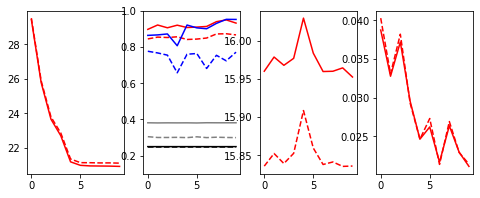

In [17]:
fig,ax = plt.subplots(1,4,figsize=(8,3))


ax[0].plot(np.array(valid_info['loss']),'--',color='r')
ax[0].plot(np.array(train_info['loss']),color='r')

ax[1].plot(np.array(valid_info['acc_z_time']),'--',color='r')
ax[1].plot(np.array(valid_info['acc_z_vel']),'--',color='b')
ax[1].plot(np.array(train_info['acc_z_time']),color='r')
ax[1].plot(np.array(train_info['acc_z_vel']),color='b')
ax[1].plot(np.array(valid_info['acc_end_time']),'--',color='black')
ax[1].plot(np.array(valid_info['acc_end_vel']),'--',color='gray')
ax[1].plot(np.array(train_info['acc_end_time']),color='black')
ax[1].plot(np.array(train_info['acc_end_vel']),color='gray')
ax[1].set_ylim(0.1,1)

ax[2].plot(np.array(valid_info['mse']),'--',color='r')
ax[2].plot(np.array(train_info['mse']),color='r')

ax[3].plot(np.array(valid_info['kld']),'--',color='r')
ax[3].plot(np.array(train_info['kld']),color='r')

plt.show()

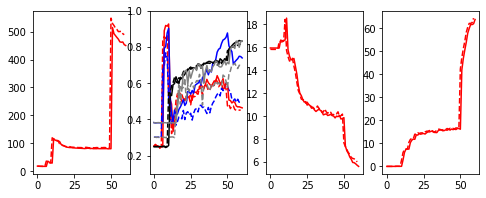

# Comparing image-in to image-out

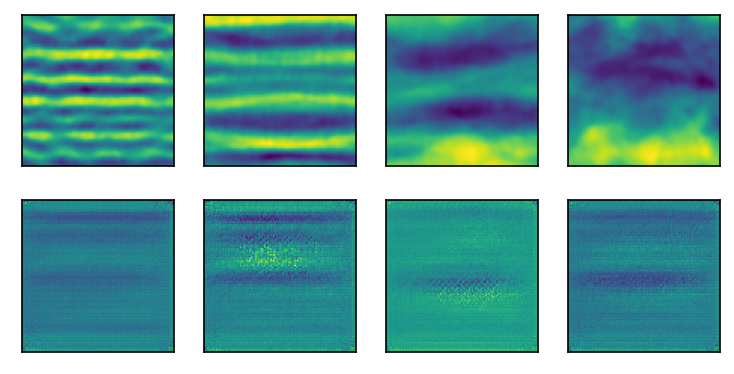

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(6,3),dpi=150)
net_VAE2.eval()
x, y = valid_ds[100]
x = x.unsqueeze(0)
with torch.no_grad():
  pred, _, _ = net_VAE2.cpu()(x)
  for t in range(4):
    x0 = x[:,t]
    pred0 = pred[:,t]  
    ax[0,t].imshow(x0[0].data.numpy())
    ax[1,t].imshow(pred0[0].data.numpy())
    ax[0,t].axes.xaxis.set_visible(False)
    ax[0,t].axes.yaxis.set_visible(False)
    ax[1,t].axes.xaxis.set_visible(False)
    ax[1,t].axes.yaxis.set_visible(False)
plt.show()

# Visualize the latent-space (using PCA)

For single images:

In [ ]:
# training data-set

encodingT = {}
net_VAE2.eval().cpu()
for t in range(4):
  encodingT[t] = []

n_test = len(train_ds)

for test_i in tqdm( range(n_test) ):
    x,y = train_ds[test_i]
    for t in range(4):    
    
      enc_item = x[t].unsqueeze(0).unsqueeze(1)
      enc_item,_ = net_VAE2.enc(enc_item)
      encodingT[t].append( enc_item.cpu().data.numpy()[0] )
    
for key in encodingT:
    encodingT[key] = np.array(encodingT[key])

encoding_set = np.concatenate([encodingT[t] for t in range(4)])

# svd

U2, S2, VT2 = np.linalg.svd(encoding_set.T,full_matrices=0)

# validation data-set

encoding = {}
net_VAE2.eval().cpu()
for t in range(4):
  encoding[t] = []

n_test = len(valid_ds)

for test_i in tqdm( range(n_test) ):
    x,y = valid_ds[test_i]
    for t in range(4):    
    
      enc_item = x[t].unsqueeze(0).unsqueeze(1)
      enc_item,_ = net_VAE2.enc(enc_item)
      encoding[t].append( enc_item.cpu().data.numpy()[0] )
    
for key in encoding:
    encoding[key] = np.array(encoding[key])

100%|██████████| 983/983 [00:33<00:00, 29.47it/s]


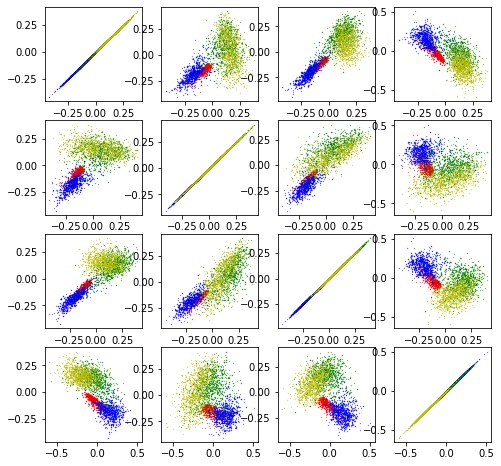

In [ ]:
# visualize the latent space

color_list = ['r','b','g','y']

big = 4
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(4):
      ax[dim1,dim2].scatter(encoding[key][:,dim1],encoding[key][:,dim2],label=str(key),s=0.05,color=color_list[key])
        
plt.show()

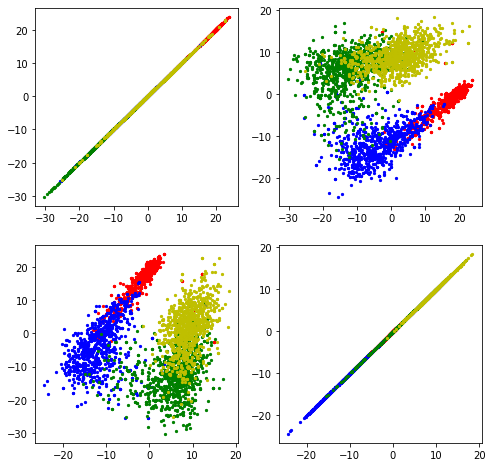

In [ ]:
# visualize the latent space using PCA

S2R=np.diag(S2)
MatR = (U2@S2R)

color_list = ['r','b','g','y']
from matplotlib.patches import Ellipse
big = 2
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(4):
      ax[dim1,dim2].scatter((encoding[key]@MatR)[:,dim1],(encoding[key]@MatR)[:,dim2],label=str(key),s=5,color=color_list[key])
        
plt.show()

For sets of 4 images:

In [ ]:
# For training-dataset

encoding3T = {}
net_VAE2.eval().cpu()
for v in range(3):
  encoding3T[v] = []

n_test = len(train_ds)

for test_i in tqdm( range(n_test) ):
    x,y = train_ds[test_i]
    enc_item = torch.cat([net_VAE2.enc(x[t].unsqueeze(0).unsqueeze(1))[0] for t in range(4)],1)
    encoding3T[y[0].item()].append( enc_item.data.numpy()[0] )
    
for key in encoding3T:
    encoding3T[key] = np.array(encoding3T[key])

encoding3_set = np.concatenate([encoding3T[v] for t in range(3)])

# svd

U3, S3, VT3 = np.linalg.svd(encoding3_set.T,full_matrices=0)


# For validation-dataset

encoding3 = {}
net_VAE2.eval().cpu()
for v in range(3):
  encoding3[v] = []

n_test = len(valid_ds)

for test_i in tqdm( range(n_test) ):
    x,y = valid_ds[test_i]
    enc_item = torch.cat([net_VAE2.enc(x[t].unsqueeze(0).unsqueeze(1))[0] for t in range(4)],1)
    encoding3[y[0].item()].append( enc_item.data.numpy()[0] )
    
for key in encoding3:
    encoding3[key] = np.array(encoding3[key])

100%|██████████| 983/983 [00:33<00:00, 29.30it/s]


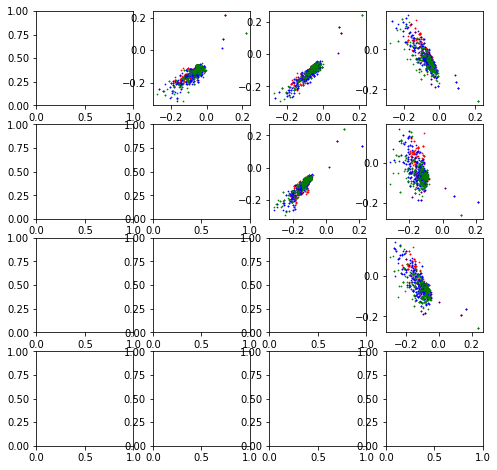

In [ ]:
# visualize the latent space

color_list = ['r','b','g','y']

big = 4
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(3):
      if dim2>dim1:
        ax[dim1,dim2].scatter(encoding3[key][:,dim1],encoding3[key][:,dim2],label=str(key),s=0.5,color=color_list[key])
        
plt.show()

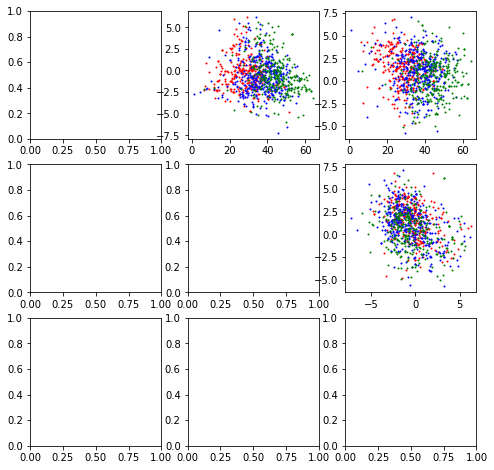

In [ ]:
# visualize the latent space using PCA

S3R=np.diag(S3)
Mat3R = (U3@S3R)


color_list = ['r','b','g','y']
from matplotlib.patches import Ellipse
big = 3
fig,ax =plt.subplots(big,big,figsize=(8,8))

for dim1 in range(big):
  for dim2 in range(big):
    for key in range(3):
      if dim2>dim1:
        ax[dim1,dim2].scatter((encoding3[key]@Mat3R)[:,dim1],(encoding3[key]@Mat3R)[:,dim2],label=str(key),s=1,color=color_list[key])
        
plt.show()
